In this notebook, we load the phenograph cluster means and apply spectral clustering to obtain metaclusters. PhenoGraph was run separately on the single-cell data from each mouse. Along with the cluster means, we also load the corresponding cluster frequencies, and for each mouse the tumor volume, cohort, and treatment metadata.

In [1]:
%matplotlib inline

In [2]:
# Set up notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (8, 8)

In [3]:
## CODE FOR SPECTRAL CLUSTERING
# The code for fixed-perplexity Gaussian is adapted from van der Maaten's Matlab drtoolbox
from scipy.spatial.distance import pdist, squareform

def hbeta(d, beta):
    """Compute Gaussian probabilities and associated entropy for a vector of
    squared Euclidean distances

    Parameters
    ----------
    d : ndarray
        Squared Euclidean distances
    beta : float
        Gaussian precision, s t. P = exp(beta * -d)

    Returns
    -------
    h : float
        The entropy of the Gaussian with d and beta
    p : ndarray
        The corresponding probabilities for each value in d
    """
    q = np.exp(-d * beta)  # Unnormalized density
    z = np.sum(q)  # Normalization factor
    h = np.log(z) + beta * np.sum(d * q) / z  # Entropy
    return h, q/z


def binary_search(d, u=30, tol=1e-5):
    """Binary search for Gaussian bandwidth that satisfies the constraint on the perplexity

    Parameters
    ----------
    d : ndarray
        A vector of squared euclidean distances
    u: int or float
        Perplexity
    tol: float
        Tolerance defining whether perplexity is sufficiently near desired value

    Returns
    -------
    p : ndarray
        A vector of probabilities corresponding to the entries in d
    beta : float
        The Gaussian precision satisfying the perplexity constraint
    """
    # Initialize min and max beta values to +/- inf
    beta_min = -np.inf
    beta_max = np.inf

    # Initialize beta as inverse standard deviation of values in d
    beta = np.std(d) ** -1
    h, p = hbeta(d, beta)

    log_u = np.log(u)
    delta_h = h - log_u
    tries = 0
    while np.abs(delta_h) > tol and tries < 50:

        # If perplexity is not within tolerance, increase or decrease precision
        if delta_h > 0:
            beta_min = beta
            if np.isinf(beta_max):
                beta *= 2
            else:
                beta += beta_max
                beta /= 2
        else:
            beta_max = beta
            if np.isinf(beta_min):
                beta /= 2
            else:
                beta += beta_min
                beta /= 2

        # Recompute Gaussian with new precision
        [h, p] = hbeta(d, beta)
        delta_h = h - log_u
        tries += 1

    if tries == 49:
        warnings.warn("Binary search ended after 50 tries")

    return p, beta


def d2p(d, i, u):
    """Convert distances to probabilities, for point i, with perplexity u
    Parameters
    ----------
    Same as binary_search
    
    Returns
    -------
    probabilities: ndarray
        A vector of probabilities corresponding to the entires in d, with a zero at index i
    """
    mask = np.ones(d.shape, dtype=bool)
    mask[i] = 0

    # Perform binary search, excluding self
    probabilities = np.zeros(d.shape, dtype=float)
    probabilities[mask], beta = binary_search(d[mask], u=u)
    
    return probabilities


def fpg_spectrum(X, perplexity, metric='sqeuclidean'):
    """Find the spectral decomposition of the Markov matrix corresponding to the FPG affinity matrix, 
    using the given perplexity.
    
    Parameters
    ----------
    X : ndarray
        A n-by-d matrix of n observations in d dimensions
    perplexity : int or float
        The parameter used for tuning the Gaussian bandwidth at each point in X,
        roughly equivalent to the "effective number of neighbors"
        Typically takes values between 10 and 60
    metric : str
        Argument passed to scipy.spatial.distance.pdist, specifying the desired distance metric
        
    Returns
    -------
    u : ndarray
        Length-n array of eigenvalues of the Markov matrix
    v : ndarray
        n-by-n matrix of eigenvectors of the Markov matrix, in same order as u. Each column is an eigenvector.
    """
    try:
        X = X.values
    except AttributeError:
        assert isinstance(X, np.ndarray)
        
    # Compute distances using metric
    D = squareform(pdist(X, metric))
    P = np.vstack(d2p(d, i, perplexity) for i, d in enumerate(D))
    # Symmetric kernel matrix
    K = .5 * (P + P.T)
    # Symmetric markov matrix
    D_inv = np.diagflat(1 / np.sqrt(K.sum(axis=1)))
    T = D_inv.dot(K).dot(D_inv)
    assert np.allclose(T, T.T)
    # Eigendecomposition
    u, v = np.linalg.eigh(T)
    assert np.isclose(1, u).sum() == 1  # Chain is ergodic
    # Sort decreasing
    ix = np.argsort(u)[::-1]
    u = u[ix]
    v = v[:, ix]
    # Recover eigenvectors for original asymmetric markov matrix
    v = D_inv.dot(v)
    assert np.allclose(v[0, 0], v[:, 0])  # First eigenvector is (normalized) all-ones
    return u, v

In [4]:
# Load cluster means and apply Z transform to each cohort separately
means = pd.read_csv('clusterMeans.csv.gz', index_col=list(range(5)))

# Z transform function
z = lambda x: (x - x.mean()) / x.std()

# Apply Z transform to each cohort separately
Z = means.groupby(level='cohort').apply(z)

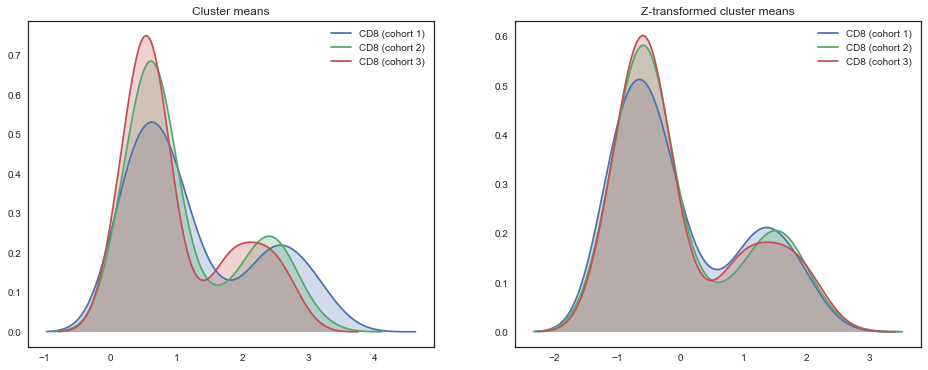

In [5]:
# Example of effect of Z transform
fig, axes = plt.subplots(ncols=2, figsize=(16, 6))
param = "CD8"

for cohort, group in means.groupby(level='cohort'):
    sns.kdeplot(group[param], shade=True, ax=axes[0], label='%s (cohort %i)' % (param, cohort))
axes[0].set_title("Cluster means")

for cohort, group in Z.groupby(level='cohort'):
    sns.kdeplot(group[param], shade=True, ax=axes[1], label='%s (cohort %i)' % (param, cohort))
axes[1].set_title("Z-transformed cluster means")

We start by obtaining the spectra of the Markov matrices associated with a wide range of perplexity values

In [6]:
# FPG spectrum of Z over range of perplexity values
# NB this is not computationally efficient but in this demo the data set is small so we save time by not optimizing
spectra = {perp: fpg_spectrum(Z.values, perp)[0] for perp in range(10, 51)}

Below, for each value of perplexity (different colored lines), we plot a peak at the location of the largest spectral gap, where the height of the peak represents the magnitude of the gap. We can see that the gap occurs at 14 for many different perplexity settings and this is also where many of the largest gaps occur.

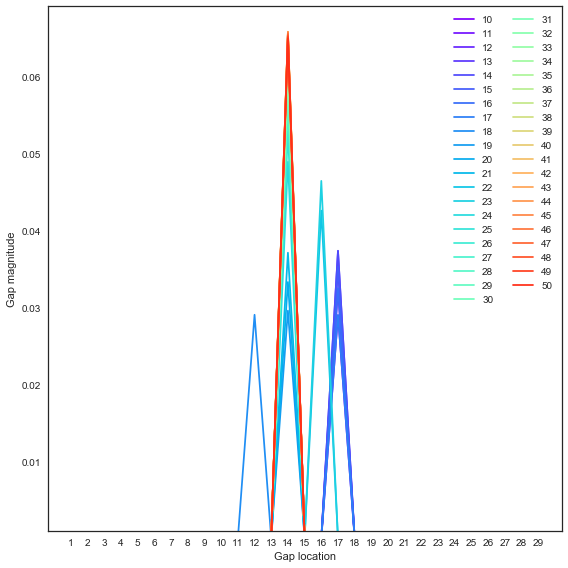

In [7]:
max_eig=30  # We're not interested in solutions with more than 30 metaclusters
colors = [plt.cm.rainbow(i) for i in range(0, 256, 256 // len(spectra))]
palette = {perp: color for perp, color in zip(sorted(spectra.keys()), colors)}
plt.figure(figsize=(8, 8))
for perp in sorted(spectra.keys()):
    spectrum = spectra[perp]
    gap_magnitudes = np.abs(np.diff(spectrum[:max_eig]))
    # Find largest gap and set all others to 0
    non_top = np.argsort(np.diff(spectrum[:max_eig]))[1:]
    gap_magnitudes[non_top] = 0
    plt.plot(np.arange(1, max_eig), gap_magnitudes, c=palette[perp], label=perp)
plt.legend(ncol=2, loc="best")
plt.xticks(range(1, max_eig));
plt.xlabel("Gap location")
plt.ylabel("Gap magnitude")
plt.ylim((.001, plt.ylim()[1]));
plt.tight_layout()

In [8]:
from collections import defaultdict
counter = defaultdict(int)
for perp, spectrum in spectra.items():
    gap_location = np.argmin(np.diff(spectrum[:max_eig])) + 1
    counter[gap_location] += 1
most_frequent_location = max(counter.keys(), key=lambda x: counter[x])
print("The most common gap location across perplexity values is at eigenvalue %i" % most_frequent_location)

The most common gap location across perplexity values is at eigenvalue 14


In [9]:
# Find the perplexity that produces the largest magnitude gap at the desired location.
from collections import namedtuple
gapinfo = namedtuple('gapinfo', "perplexity location magnitude".split())
gaps = list()
for perp in sorted(spectra.keys()):
    spectrum = spectra[perp][:max_eig]
    ix = np.argsort(np.diff(spectrum))
    location = ix[0] + 1
    magnitude = np.abs(np.diff(spectrum)[ix[0]])
    gaps.append(gapinfo(perp, location, magnitude))
    
max_magnitude = 0
for gapinfo in gaps:
    if gapinfo.location == most_frequent_location and gapinfo.magnitude > max_magnitude:
        perplexity = gapinfo.perplexity
        max_magnitude = gapinfo.magnitude
print("The perplexity setting that produces the largest gap at eigenvalue %i is %i " % (most_frequent_location, perplexity))

The perplexity setting that produces the largest gap at eigenvalue 14 is 43 


Now we run spectral clustering using the optimal perplexity

In [10]:
from sklearn.cluster import KMeans
def spectral_cluster(X, perplexity, max_components, metric='sqeuclidean'):
    u, v = fpg_spectrum(X, perplexity, metric)
    u = u[:max_components]
    v = v[:, :max_components]
    k = np.argmin(np.diff(u)) + 1
    kmeans = KMeans(n_clusters=k, n_init=500, random_state=0).fit(v[:, 1:k+1])
    return kmeans.labels_


mc = spectral_cluster(Z.values, perplexity, max_components=max_eig)
assert len(set(mc)) == most_frequent_location

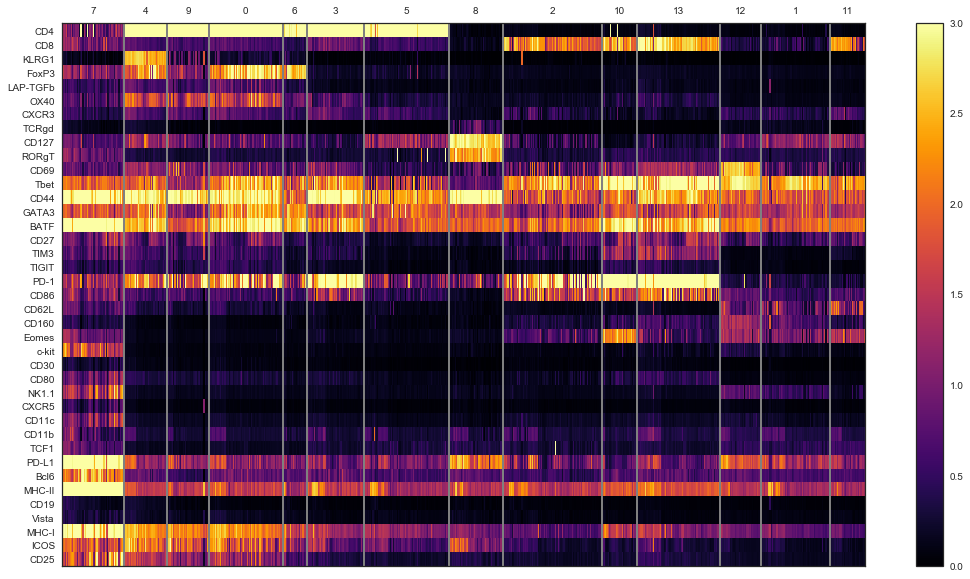

In [11]:
# Visualize metaclusters
from scipy.cluster.hierarchy import linkage, leaves_list
from scipy.spatial.distance import pdist
def order_columns(X, metric='euclidean', method='average'):
    y = pdist(X.T, metric=metric)
    Z = linkage(y, method=method)
    return leaves_list(Z)

def order_rows(X, metric='euclidean', method='average'):
    y = pdist(X, metric=metric)
    Z = linkage(y, method=method)
    return leaves_list(Z)

def sorted_cluster_heatmap(X, labels):
    tmp = X.copy()
    tmp['metacluster'] = labels
    tmp = tmp.set_index('metacluster', append=True)
    corder = order_rows(tmp.groupby(level='metacluster').mean())
    groups = []
    groupsizes = []
    for i in corder:
        groups.append(tmp.xs(i, level='metacluster'))
        groupsizes.append(sum(tmp.index.get_level_values('metacluster') == i))
    lines = np.cumsum(groupsizes) + .5
    tmp = pd.concat(groups)

    q = order_columns(X.values, metric='cosine', method='complete')

    # Rearrange so CD4 and CD8 are first two
    q = list(q)
    q.remove(21)
    q.remove(22)
    q = [21, 22] + q
    plt.figure(figsize=(18, 10))
    plt.matshow(tmp.values[:, q].T, fignum=False, aspect='auto', cmap=plt.cm.inferno, vmin=0, vmax=3)
    for line in lines[:-1]:
        plt.axvline(line, ls='-', c=(.5, .5, .5), lw=2)
    plt.xlim((0, len(X)))
    lines = np.append(0, lines)
    plt.xticks(.5 * (lines[1:] + lines[:-1]), corder)
    plt.yticks(range(len(X.columns)), X.columns[q]);
    plt.ylim((len(q) - .5, -.6))
    plt.colorbar()

sorted_cluster_heatmap(means, mc)

Having obtained the metacluster assignments, we can now examine metacluster frequencies as a function of treatment

In [12]:
# Add metacluster assignments to Z's index
Z['metacluster'] = mc
Z = Z.set_index('metacluster', append=True)

In [13]:
# Extract metadata from Z index as data frame
df = Z.reset_index().loc[:, Z.index.names]
df.index = pd.Index([i.split('-')[0] for i in df['phenograph']], name='mouse_id')  # Mouse ID is first part of phenograph label
# Add everything but frequency back to index
df = df.set_index('treatment phenograph metacluster tumor_vol cohort'.split(), append=True)
# Sum frequencies of all clusters assigned to the same metacluster within each mouse
# In the resulting data frame, each column is a metacluster, each row is a mouse, and the value is the MC frequency for that mouse
mc_frequencies = df.unstack(level='metacluster').groupby(level='mouse_id').sum().fillna(0)

# Add treatment and tumor_vol metadata to mc_frequencies 
treatment_key = dict()
tumor_vol = dict()
for phenograph_id, treatment, vol in zip(Z.index.get_level_values('phenograph'),
                                         Z.index.get_level_values('treatment'),
                                         Z.index.get_level_values('tumor_vol')):
    mouse = phenograph_id.split("-")[0]
    treatment_key[mouse] = treatment
    tumor_vol[mouse] = vol

mc_frequencies['treatment'] = [treatment_key[mouse] for mouse in mc_frequencies.index]
mc_frequencies['tumor_vol'] = [tumor_vol[mouse] for mouse in mc_frequencies.index]
mc_frequencies = mc_frequencies.set_index(['treatment', 'tumor_vol'], append=True)

# Clean up
mc_frequencies = mc_frequencies.reorder_levels(['treatment', 'mouse_id', 'tumor_vol']).sort_index()
mc_frequencies.columns = mc_frequencies.columns.droplevel(0)

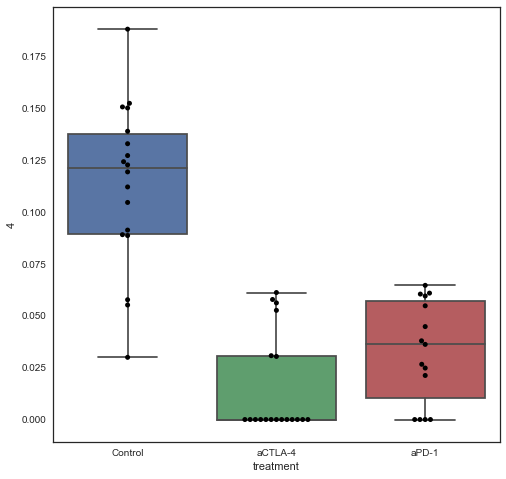

In [14]:
plt.figure(figsize=(8, 8))
mc_label = 4
sns.boxplot(x='treatment', y=mc_label, data=mc_frequencies.reset_index())
sns.swarmplot(x='treatment', y=mc_label, data=mc_frequencies.reset_index(), color='k')

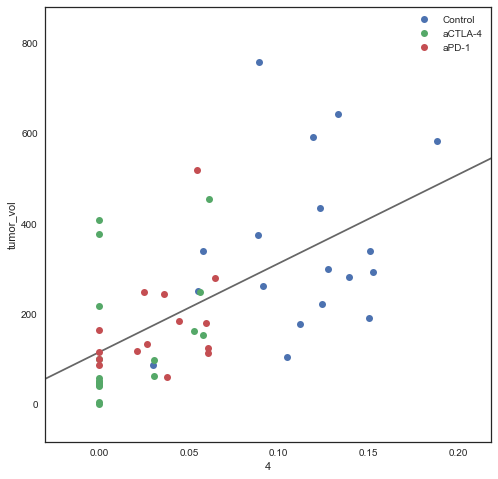

In [15]:
def scatter_with_lsline(x, y, groupvar, data):    
    # Scatter each group
    for name, group in data.groupby(groupvar):
        plt.plot(group[x], group[y], 'o', label=name)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.legend()
    
    # Adjust lims
    xrange = plt.xlim()[1] - plt.xlim()[0]
    yrange = plt.ylim()[1] - plt.ylim()[0]
    plt.xlim((plt.xlim()[0] - .1 * xrange, plt.xlim()[1] + .1 * xrange))
    plt.ylim((plt.xlim()[0] - .1 * yrange, plt.ylim()[1] + .1 * yrange))
    
    # lsline
    p = np.polyfit(data[x], data[y], 1)
    xvals = np.arange(plt.xlim()[0], 1.1 * plt.xlim()[1], xrange / 100)
    plt.plot(xvals, np.polyval(p, xvals), color=(.4, .4, .4), zorder=0)
    
scatter_with_lsline(mc_label, 'tumor_vol', 'treatment', mc_frequencies.reset_index())